<a href="https://colab.research.google.com/github/sherax139/Graph-Neural-Network-model/blob/main/GNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cpu.html
     |████████████████████████████████| 286 kB 9.4 MB/s 
     |████████████████████████████████| 641 kB 55.5 MB/s 
     |████████████████████████████████| 311 kB 54.3 MB/s 
     |████████████████████████████████| 121 kB 56.8 MB/s 
     |████████████████████████████████| 467 kB 7.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=780d7d7d4e8f2a1f2347b93f3f01509eae88da878e231f708466301cd53b341c
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [2]:
# Enforce pytorch version 1.6.0
import torch
if torch.__version__ != '1.6.0':
  !pip uninstall torch -y
  !pip uninstall torchvision -y
  !pip install torch==1.6.0
  !pip install torchvision==0.7.0

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

Found existing installation: torch 1.12.1+cu113
Uninstalling torch-1.12.1+cu113:
  Successfully uninstalled torch-1.12.1+cu113
Found existing installation: torchvision 0.13.1+cu113
Uninstalling torchvision-0.13.1+cu113:
  Successfully uninstalled torchvision-0.13.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 748.8 MB 17 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.9 requires torchvision>=0.8.2, which is not installed.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.6.0 which is incompatible.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.9 MB 6.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.9 requires torch<1.14,>=1.7, but you have torch 1.6.0 which is incompatible.
fastai 2.7.9 requires torchvision>=0.8.2, but you have torchvision 0.7.0 which is incompatible.
1.6.0
10.2
Python 3.7.13
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import numpy as np

In [4]:
import torch.nn as nn
import torch


In [5]:
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader
#load the dataset

data = MNISTSuperpixels(root = 'data/')
data

Extracting data/raw/MNISTSuperpixels.zip
Processing...
Done!


MNISTSuperpixels(60000)

In [6]:
#Analyzing the dataset
print('==============')
print("dataset type: ", type(data))
print("dataset features: ", data.num_features)
print("dataset target: ", data.num_classes)
print("dataset length: ", data.len)
print("dataset sample: ", data[0])
print("sample nodes: ", data[0].num_nodes)
print("sample edges: ", data[0].num_edges)
print("===============")

dataset type:  <class 'torch_geometric.datasets.mnist_superpixels.MNISTSuperpixels'>
dataset features:  1
dataset target:  10
dataset length:  <bound method InMemoryDataset.len of MNISTSuperpixels(60000)>
dataset sample:  Data(x=[75, 1], edge_index=[2, 1399], y=[1], pos=[75, 2])
sample nodes:  75
sample edges:  1399


In [7]:
data[0].x.shape

torch.Size([75, 1])

In [8]:
data[0].edge_index.t()

tensor([[ 0,  3],
        [ 0,  8],
        [ 0, 10],
        ...,
        [74, 55],
        [74, 63],
        [74, 69]])

In [10]:
dataset = data[0]

In [11]:
dataset.y

tensor([5])

In [12]:
import torch 
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [16]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size*2, data.num_classes)
    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(1, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
Number of parameters:  13898


In [17]:
data_size = len(data)

In [18]:
data_size

60000

In [26]:
from torch_geometric.data import DataLoader
import warnings
loss_fn = torch.nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(model.parameters(), lr = 0.005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data_size = len(data)
no_of_graph_per_batch = 64
loader = DataLoader(data[:int(data_size*0.8)],
                    batch_size = no_of_graph_per_batch, shuffle = True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=no_of_graph_per_batch, shuffle=True)


def train(data):
  for batch in loader:
    batch.to(device)
    optimizer.zero_grad()
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    loss = torch.sqrt(loss_fn(pred, batch.y))
    loss.backward()
    optimizer.step()
    return loss, embedding

print("Starting training....")
losses = []
for epoch in range(500):
  loss, h = train(data)
  losses.append(loss)
  if epoch % 10 ==0:
    print(f"Epoch {epoch} | Train Loss {loss}")


Starting training....
Epoch 0 | Train Loss 1.3776870965957642
Epoch 10 | Train Loss 1.4481326341629028
Epoch 20 | Train Loss 1.4822973012924194
Epoch 30 | Train Loss 1.422312617301941
Epoch 40 | Train Loss 1.4760029315948486
Epoch 50 | Train Loss 1.4586259126663208
Epoch 60 | Train Loss 1.4429094791412354
Epoch 70 | Train Loss 1.4547369480133057
Epoch 80 | Train Loss 1.3727623224258423
Epoch 90 | Train Loss 1.420947551727295
Epoch 100 | Train Loss 1.4405310153961182
Epoch 110 | Train Loss 1.4501688480377197
Epoch 120 | Train Loss 1.4527790546417236
Epoch 130 | Train Loss 1.4444977045059204
Epoch 140 | Train Loss 1.4554466009140015
Epoch 150 | Train Loss 1.4476327896118164
Epoch 160 | Train Loss 1.4330946207046509
Epoch 170 | Train Loss 1.4282771348953247
Epoch 180 | Train Loss 1.3976860046386719
Epoch 190 | Train Loss 1.4331430196762085
Epoch 200 | Train Loss 1.4267405271530151
Epoch 210 | Train Loss 1.4445383548736572
Epoch 220 | Train Loss 1.4538798332214355
Epoch 230 | Train Loss 1.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


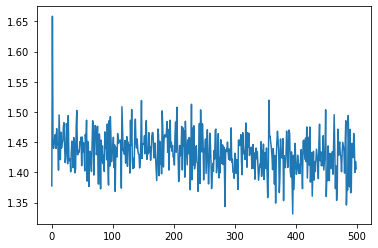

In [28]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

In [30]:
import pandas as pd 
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    pred=torch.argmax(pred,dim=1)
print(test_batch.y[0])#Actual REsult
print(pred[0])#Predicted Result

tensor(0)
tensor(1)


In [36]:
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [37]:
data

MNISTSuperpixels(60000)

Is undirected: True


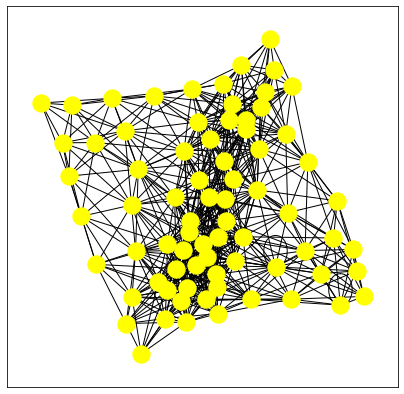

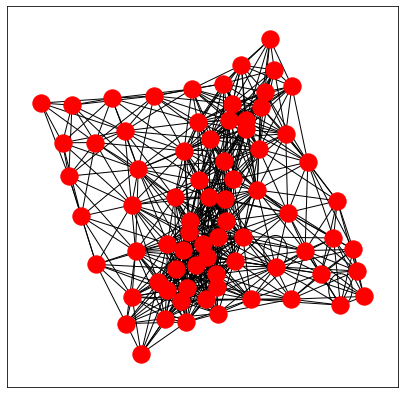

In [48]:
dataset=data[3]
print(f'Is undirected: {dataset.is_undirected()}')
from torch_geometric.utils import to_networkx
G = to_networkx(dataset, to_undirected=True)
 
visualize(G, "yellow")
visualize(G, "red")

In [49]:
dataset.y

tensor([1])